Targets: 
1. In order for model to converge better, we will introduce learning rate reduction strategy.

Results: 
1. Best Train accuracy: 99.17% (15th epoch)
2. Best Test accuracy:  99.49% (12th epoch)
3. Parameters: 7878

Analysis:
1. Target accuracy is achieved.
2. Accuracy is stable and over 99.4% for 7 epochs continuously.

# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomPerspective(0.3, 0.5, fill=(0,)),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(0,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.cblock1 = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1, bias=False),    # Input -  28x28x1, Output -  28x28x8, RF - 3x3
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 10, 3, padding=1, bias=False),   # Input -  28x28x8, Output - 28x28x10, RF - 5x5
            nn.ReLU(),
        )

        self.tblock1 = nn.Sequential(
            nn.MaxPool2d(2, 2),                           # Input - 28x28x10, Output - 14x14x10, RF - 6x6
        )

        self.cblock2 = nn.Sequential(
            nn.BatchNorm2d(10),
            nn.Conv2d(10, 16, 3, padding=1, bias=False),  # Input - 14x14x10, Output - 14x14x16, RF - 10x10
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, 3, padding=1, bias=False),  # Input - 14x14x16, Output - 14x14x16, RF - 14x14
            nn.ReLU(),
        )

        self.tblock2 = nn.Sequential(
            nn.MaxPool2d(2, 2),                           # Input - 14x14x16, Output -   7x7x16, RF - 16x16
        )

        self.cblock3 = nn.Sequential(
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, 3, padding=1, bias=False),  # Input -   7x7x16, Output -   7x7x16, RF - 24x24
            nn.ReLU(),
        )

        self.outblock = nn.Sequential(
            nn.AvgPool2d(7, 7),                           # Input -   7x7x16, Output -   1x1x16, RF - 48x48
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, 1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 10, 1),
            nn.Flatten(),
            nn.LogSoftmax()
        )

    def forward(self, x):
        x = self.cblock1(x)
        x = self.tblock1(x)
        x = self.cblock2(x)
        x = self.tblock2(x)
        x = self.cblock3(x)
        x = self.outblock(x)
        return x

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
            Conv2d-4           [-1, 10, 28, 28]             720
              ReLU-5           [-1, 10, 28, 28]               0
         MaxPool2d-6           [-1, 10, 14, 14]               0
       BatchNorm2d-7           [-1, 10, 14, 14]              20
            Conv2d-8           [-1, 16, 14, 14]           1,440
              ReLU-9           [-1, 16, 14, 14]               0
      BatchNorm2d-10           [-1, 16, 14, 14]              32
           Conv2d-11           [-1, 16, 14, 14]           2,304
             ReLU-12           [-1, 16, 14, 14]               0
        MaxPool2d-13             [-1, 16, 7, 7]               0
      BatchNorm2d-14             [

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

    return test_loss

# Let's Train and test our model

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=0, verbose=True, factor=0.5)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test_loss = test(model, device, test_loader)
    scheduler.step(test_loss)

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
Loss=0.22919248044490814 Batch_id=937 Accuracy=93.47: 100%|██████████| 938/938 [00:30<00:00, 31.22it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0557, Accuracy: 9825/10000 (98.25%)

EPOCH: 1


Loss=0.08500741422176361 Batch_id=937 Accuracy=97.59: 100%|██████████| 938/938 [00:30<00:00, 31.10it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0445, Accuracy: 9857/10000 (98.57%)

EPOCH: 2


Loss=0.0715598315000534 Batch_id=937 Accuracy=98.05: 100%|██████████| 938/938 [00:30<00:00, 31.19it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 9915/10000 (99.15%)

EPOCH: 3


Loss=0.03839350864291191 Batch_id=937 Accuracy=98.27: 100%|██████████| 938/938 [00:30<00:00, 31.13it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0319, Accuracy: 9902/10000 (99.02%)

Epoch     4: reducing learning rate of group 0 to 5.0000e-03.
EPOCH: 4


Loss=0.10136952251195908 Batch_id=937 Accuracy=98.66: 100%|██████████| 938/938 [00:30<00:00, 31.23it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9918/10000 (99.18%)

EPOCH: 5


Loss=0.021269535645842552 Batch_id=937 Accuracy=98.79: 100%|██████████| 938/938 [00:30<00:00, 31.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9916/10000 (99.16%)

EPOCH: 6


Loss=0.22009293735027313 Batch_id=937 Accuracy=98.89: 100%|██████████| 938/938 [00:30<00:00, 30.37it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9929/10000 (99.29%)

EPOCH: 7


Loss=0.06544814258813858 Batch_id=937 Accuracy=98.83: 100%|██████████| 938/938 [00:30<00:00, 30.56it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9922/10000 (99.22%)

Epoch     8: reducing learning rate of group 0 to 2.5000e-03.
EPOCH: 8


Loss=0.0009423815063200891 Batch_id=937 Accuracy=98.95: 100%|██████████| 938/938 [00:30<00:00, 30.70it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9940/10000 (99.40%)

EPOCH: 9


Loss=0.2554873526096344 Batch_id=937 Accuracy=98.95: 100%|██████████| 938/938 [00:30<00:00, 30.62it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9943/10000 (99.43%)

Epoch    10: reducing learning rate of group 0 to 1.2500e-03.
EPOCH: 10


Loss=0.022567009553313255 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [00:30<00:00, 30.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9941/10000 (99.41%)

EPOCH: 11


Loss=0.003427601885050535 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [00:30<00:00, 30.59it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9949/10000 (99.49%)

EPOCH: 12


Loss=0.05106953904032707 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:30<00:00, 30.43it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9947/10000 (99.47%)

Epoch    13: reducing learning rate of group 0 to 6.2500e-04.
EPOCH: 13


Loss=0.04912450164556503 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [00:30<00:00, 30.53it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9944/10000 (99.44%)

Epoch    14: reducing learning rate of group 0 to 3.1250e-04.
EPOCH: 14


Loss=0.14441996812820435 Batch_id=937 Accuracy=99.17: 100%|██████████| 938/938 [00:30<00:00, 30.57it/s]



Test set: Average loss: 0.0162, Accuracy: 9948/10000 (99.48%)



Text(0.5, 1.0, 'Test Accuracy')

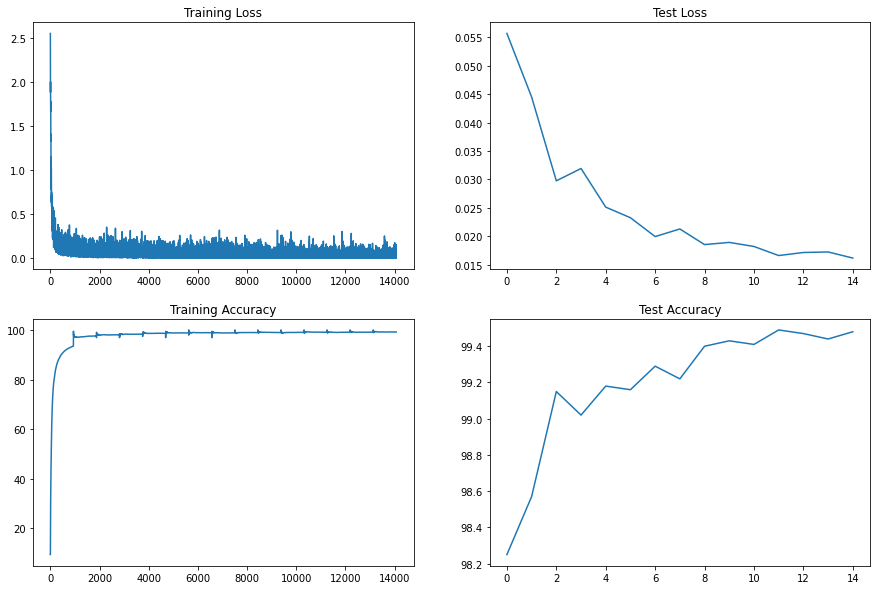

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")